# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords as nltk_stopwords 
from nltk.stem import WordNetLemmatizer 
import re
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

def prepare_text_1(corp):
    lemmatizer = WordNetLemmatizer()
    list_of_prepare_text=[]
    for comment in corp:
        text = ''.join(lemmatizer.lemmatize(comment))
        text = re.sub(r'[^a-zA-Z]', ' ', text) 
        text=text.split()
        text=" ".join(text)
        list_of_prepare_text.append( text )
    return list_of_prepare_text

In [2]:
def prepare_text_2(corp):
    lemmatizer = WordNetLemmatizer()
    list_of_prepare_text=[]
    corp = corp.values.astype('U')
    for comment in corp:
        text = re.sub(r'[^a-zA-Z]', ' ', comment)
        text=text.split()
        text=" ".join(text)
        text = ''.join(lemmatizer.lemmatize(text))
        list_of_prepare_text.append( text )
    return list_of_prepare_text

In [3]:
#df= pd.read_csv('toxic_comments.csv')
df= pd.read_csv('/datasets/toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


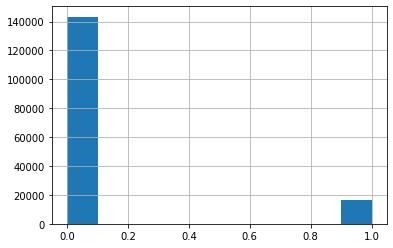

In [4]:
df['toxic'].hist()

Явный дисбаланс классов, при обучении моделей стоит применить взвешивание классов.

In [5]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [6]:
%%time
list_of_prepare_text=prepare_text_2(df['text'])
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

CPU times: user 13.4 s, sys: 2.14 s, total: 15.5 s
Wall time: 16.1 s


In [7]:
train_text , test_text, target_train_toxic , target_test_toxic, = train_test_split(list_of_prepare_text,df['toxic'], test_size=0.2,shuffle=False)

In [8]:
len(train_text) , len(test_text) , len(target_train_toxic) , len(target_test_toxic)

(127656, 31915, 127656, 31915)

In [9]:
tf_idf_train_features = count_tf_idf.fit_transform(train_text)
tf_idf_test_features = count_tf_idf.transform(test_text)

# 2. Обучение

In [10]:
%%time
model = LogisticRegression(class_weight = 'balanced')
model.fit(tf_idf_train_features, target_train_toxic )
f1_score(target_test_toxic,model.predict(tf_idf_test_features))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 8.14 s, sys: 6.25 s, total: 14.4 s
Wall time: 14.4 s


0.7551020408163266

In [11]:
%%time
max_iter_LR = 200
parameters_LR = { 'max_iter':range(100,max_iter_LR,20), 'C':np.arange(1,2,0.2) }
model_LR = LogisticRegression (random_state=12345,class_weight = 'balanced')
model_LR_GSCV = GridSearchCV ( model_LR, parameters_LR )
model_LR_GSCV.fit( tf_idf_train_features, target_train_toxic )
best_model_LR_GSCV = model_LR_GSCV.best_estimator_
f1_score(target_test_toxic , best_model_LR_GSCV.predict(tf_idf_test_features))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 9min 44s, sys: 9min 18s, total: 19min 3s
Wall time: 19min 3s


0.7618647627047459

In [12]:
best_model_LR_GSCV

LogisticRegression(C=1.7999999999999998, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
%%time
max_depth_DTR = 20
parameters_DTR = { 'max_depth':range(10,max_depth_DTR,5), }
model_DTR = DecisionTreeClassifier (random_state=12345 , class_weight = 'balanced')
model_DTR_GSCV = GridSearchCV ( model_DTR, parameters_DTR )
model_DTR_GSCV.fit( tf_idf_train_features, target_train_toxic )
best_model_DTR_GSCV = model_DTR_GSCV.best_estimator_
f1_score( target_test_toxic ,best_model_DTR_GSCV.predict(tf_idf_test_features))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 2min 27s, sys: 0 ns, total: 2min 27s
Wall time: 2min 28s


0.5484414490311711

# 3. Выводы

* Проведенна подготовка признаков с импользованием таких методов как:
    * Лемматизация
    * Очистка датасета от всего лишнего кроме английских букв
    * Оценен дисбаланс классов
* Обученно несколько моделей с применением кросс валидации и взвешиванием классов
* Достигнуто значение метрики F1 не меньше 0.75

Хотелось бы ещё попробобвать bert, однако:
1. Я так и не понял как с ним работать благодаря тому что тренажер принимает любой вариант.
2. Даже линейная регрессия считается очень тяжело на этом сервере. 
3. Сроки поджимают(c понедельника каникулы). 

P.S. Попробую c bert поиграть локально. Если будут недочёты и правки попробую туда этот bert добавить.

P.S.S. Не успеваю с bert добавить, увы.
Все замечания учёл.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны